## Introduction:

This code was used to analyze high speed movies of cilia in regenerating Stentor coeruleus for figure 3 of [this paper](https://www.biorxiv.org/content/10.1101/681908v1)) by Wan et al. The movies for figure 3 can be found in the supporting information.


Stentor is a single celled organism that possesses remarkable regeneration capabilities and distinctive morphology. At the anterior side of the cell is the oral primordium, a mouth-like structure surrounded by a ring of cilia which beat synchronously in a metachronal manner. Certain environmental perturbations such as a sucrose shock cause Stentor coeruleus to shed the cilia surrounding its oral primordium and regenerate the cilia over the course of ~8 hours.


When the cilia first emerge, they lack any coherent beating pattern. The goal of this analysis is to highlight when ciliary coordination in Stentor emerges following a sucrose shock. In order to achieve this, briefly, we acquired high speed movies of the beating cilia in regenerating Stentor coeruleus using brightfield microscopy. Greyscale intensities were measured from manually de- fined regions of interest and cross-correlated to determine how the spatiotempoeral coordination exhibited by the beating cilia changes over time.

In [63]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [64]:
vid_path = './data/20190422_cilia_1250shock_1911maging_20x_optovarin_ph0_polyd_50_1000fps.avi'
cilia_path = './data/20190422_cilia_1250shock_1911maging_20x_optovarin_ph0_polyd_50_1000fps_cilia.txt'

#vid_path = './data/normal_stentor_cilia_20x_optovarin_ph0_polyd_50_beads_1000_1000fps_subset.avi'
#cilia_path = './data/normal_stentor_cilia_20x_optovarin_ph0_polyd_50_beads_1000_1000fps_subset_cilia.txt'

pixel_size = 1.5 # microns per pixel in the image
fps = 1000 # frames per second in the movie
sample_freq = 1 # our sampling frequency in microns when we interpolate the ciliary band
box_width = 15 # width of box used to average out the intensities
box_length = 3 # length of box used to average out the intensities
max_dx = 21 # maximum delta in x for autocorrelation
max_dt = 801 # maximum delta in t for autocorrelation

In [65]:
import cv2
import numpy as np
import pandas as pd
import scipy
from scipy import interpolate
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## Opening the files
This code was written for movies saved as .avi files. This may need to be modified for other file formats. 

The cilia were manually defined using [Fiji](https://imagej.net/Fiji). First, the segmented line tool was used to define a region of interest (ROI). Then, the ROI then saved as XY coordinates. Because our movies do not contain metadata referring to pixel size, the coordinates correspond to pixels rather than physical distance. Our movies are also small enough that I load the entire movie into memory. This step may take a while.

In [66]:
movie = cv2.VideoCapture(vid_path)
t = int(movie.get(7))  # number of frames
y = int(movie.get(3))  # width of frame
x = int(movie.get(4))  # height of frame

vid = np.zeros((x, y, t))
for i in range(t):
    ret, image = movie.read()
    im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    vid[:, :, i] = im

movie.release()
print("opened the video!")

vid = vid.astype(np.uint8)

# normalizes the movie in order to account for differences in lighting across the field of view
vid_min = np.min(vid, axis = 2)[:, :, np.newaxis]
vid_max = np.max(vid, axis = 2)[:, :, np.newaxis]
vid_norm = (vid - vid_min)/(vid_max - vid_min)
del vid  # free up memory

points_manual = np.loadtxt(cilia_path)

opened the video!


## Interpolating the ciliary band

The points which are used to manually define the cilia are irregularly spaced and relatively sparse. We will define a parametric curve that describes the ciliary band using the points we've manually picked and then use the parametric curve to generate points regularly spaced sample_freq microns apart. 

In [67]:
x_manual = points_manual[:, 0]
y_manual = points_manual[:, 1]

# Generates a parameterization where the parameter is proportional to distance between the points 
# (in pixels)
t_manual = np.cumsum(np.sqrt( (x_manual[1:] - x_manual[:-1]) ** 2 
                            + (y_manual[1:] - y_manual[:-1]) ** 2) )
t_manual = np.append([0], t_manual)

 
# spline parameters 
s = 5 # smoothness
k = 3 # spline order

# Generates points on the cilia are spaced sample_freq microns apart
tckp, u = interpolate.splprep([x_manual, y_manual], u = t_manual, s = s, k = k)
t_new = np.linspace(0, int(t_manual[-1]), num = int(t_manual[-1] / (pixel_size * sample_freq)))
[x_cilia, y_cilia] = interpolate.splev(t_new, tckp)

# Refines the model slightly by accounting for differences between the parameter and physical distance
cilia_dist = np.sqrt( (x_cilia[1:] - x_cilia[:-1]) ** 2
                    + (y_cilia[1:] - y_cilia[:-1]) ** 2)
cilia_dist = np.append([0], cilia_dist)
t_final = np.cumsum(np.diff(t_new) * pixel_size / cilia_dist[1:])
t_final = np.append([0], t_final)
[x_cilia, y_cilia] = interpolate.splev(t_final, tckp)


## Calculating the image intensity along the cilia

We could simply use the intensity at each defined point in order to calculate the autocorrelations, but then the measurements become sensitive to where along the cilia the band is defined. In order to get around this, for each points in our parameterized curve we will instead define a box centered at that point which goes perpendicular to the curve. We will calculate the mean intensity of the pixels in every box for each frame of a movie and store this information into a dataframe

In [68]:
# rounding the defined points so that we can use it as an index in our matrix
x_int = np.round(x_cilia).astype(np.int16)
y_int = np.round(y_cilia).astype(np.int16)

# we will take into account the differences between the rounded index and the precise point along the cilia
x_resid = x_cilia - x_int
y_resid = y_cilia - y_int

dx = x_cilia[:-2] - x_cilia[2:]
dy = y_cilia[:-2] - y_cilia[2:]

# calculating the angle perpendicular to the drawn line
theta = np.arctan(dx/dy) * 180 / np.pi  # dx/dy instead of -dx/dy
                                        # because the y axis is inverted
num_pts = np.size(theta)

# initializing the dataframe where we will store the local intensity around each point in the cilia
c_intensity = pd.DataFrame(index = pd.Index(1/fps * np.arange(t)),
                           columns = pd.Index(range(num_pts)))
c_intensity.index.name = 'Time (s)'
c_intensity.columns.name = 'Position along the cilia (microns)'

# making a small centered mask in the shape of a box (angle = 0) 
box = np.zeros((box_width + box_length + 1,
                box_width + box_length + 1))
center = int((box_width + box_length)/2) + 1
box[center - int((box_length + 1)/2): center + int(box_length/2),
    center - int((box_width + 1)/2): center + int(box_width/2)] = 1

# iterates along the points in the cilia
for i in range(num_pts):
    
    # rotates the box by the local angle theta and translates it by the residuals
    rot = cv2.getRotationMatrix2D((center - 1, center - 1), theta[i], 1)
    mask = cv2.warpAffine(box, rot, (box_width + box_length + 1, box_width + box_length + 1))
    trans = np.float32([[1, 0, x_resid[i + 1]], [0, 1, y_resid[i + 1]]])
    mask = cv2.warpAffine(mask, trans, (box_width + box_length + 1, box_width + box_length + 1))

    # normalizes the mask
    mask = mask * (box_width * box_length) / np.sum(mask)
    mask = np.expand_dims(mask, axis = 2)

    # multiplies the relevant region of the cilia with the mask, sums, and stores the value in the dataframe
    cilia = mask * vid_norm[y_int[i+1] - center : y_int[i+1] + center - 1, 
                            x_int[i+1] - center : x_int[i+1] + center - 1, 
                            :]

    c_intensity[i] = np.sum(cilia, axis = (0, 1))
c_intensity.to_pickle((vid_path[:-4] + '_ciliakymograph.pkl').replace('/data/', '/output/'))

## Calculating the 2-D autocorrelations


The auto-correlation $c(\delta t, \delta x)$ is given by:
$$ c(\delta t, \delta x) = \frac
{\sum_{t, x}^{t - \delta t, x - \delta x}{[f(t, x) - \overline f(t, x)][f(t + \delta t, x + \delta x) - \overline f(t + \delta t, x + \delta x)]}}
{\{ \sum_{t, x}^{t - \delta t, x - \delta x} [f(t, x) - \overline f(t, x)]^2 \sum_{t, x}^{t - \delta t, x - \delta x} [f(t + \delta t, x + \delta x) - \overline f(t + \delta t, x + \delta x)]^2 \} ^{0.5}}$$

where $f(t, x)$ is the image intensity along the cilia at time $t$ and point $x$, and $\overline f (t, x)$ is the mean of $f (t, x)$ in the region sampled.

We chose to implement the autocorrelation this way instead of comparing a specific subset of the ciliary intensity (a ‘template’) to the entire data set. During regeneration, the ciliary motion is heterogeneous in both time and space and we did not want the results to be dependent on the specific template chosen; instead the whole data set is used.

This is unfortunately calculated using a series of for loops. This can almost certainly be sped up using FFT or vectorization, using the scipy.signal library and the convolve2D function. Alternatively, you may want to consult [this paper](https://ncorr.com/download/publications/lewisfast.pdf) for a speedy algorithm. The code as-is runs fast enough (~1-2 minutes) for the data sets we generated on my machine.

In [69]:
c = np.ones((max_dt, max_dx))
t0 = time.time()

# calculating the autocorrelation for various values of dt, dx
for dx in range(1, max_dx):
    for dt in range(1, max_dt):
        a = c_intensity.values[dt:, dx:]
        a_norm = (a - a.mean()) / (np.sqrt(np.size(a)) * np.std(a))
        b = c_intensity.values[:-dt, :-dx]
        b_norm = (b - b.mean()) / (np.sqrt(np.size(b)) * np.std(b))

        c[dt, dx] = np.sum(a_norm * b_norm)
        
# calculating for the case of dt = 0 because of how indexing works
for dx in range(1, max_dx):
    a = c_intensity.values[:, dx:]
    a_norm = (a - a.mean()) / (np.sqrt(np.size(a)) * np.std(a)) 
    b = c_intensity.values[:, :-dx]
    b_norm = (b - b.mean()) / (np.sqrt(np.size(b)) * np.std(b))
    c[0, dx] = np.sum(a_norm * b_norm)
        
# calculating for the case of dx = 0 because of how indexing works
for dt in range(1, max_dt):
    a = c_intensity.values[dt:, :]
    a_norm = (a - a.mean()) / (np.sqrt(np.size(a)) * np.std(a)) 
    b = c_intensity.values[:-dt, :]
    b_norm = (b - b.mean()) / (np.sqrt(np.size(b)) * np.std(b))
    c[dt, 0] = np.sum(a_norm * b_norm)
t1 = time.time()
print('Total time to calculate autocorrelation: %d seconds' %(t1 - t0))

# wrapping the numpy array in a pandas DataFrame and saving the result
correlation = pd.DataFrame(data = c,
                           index = pd.Index(1/fps * np.arange(max_dt)),
                           columns = pd.Index(range(max_dx)))
correlation.index.name = 'dt (s)'
correlation.columns.name = 'dx (microns)'
correlation.to_pickle((vid_path[:-4] + '_autocorrelation.pkl').replace('/data/', '/output/'))

Total time to calculate autocorrelation: 463 seconds


# Plotting the results:

The figures in [our paper](https://www.biorxiv.org/content/10.1101/681908v1) were plotted in Matlab with a slightly different colormap. This is for illustrative purposes.

Text(0.5, 0, 'dt (ms)')

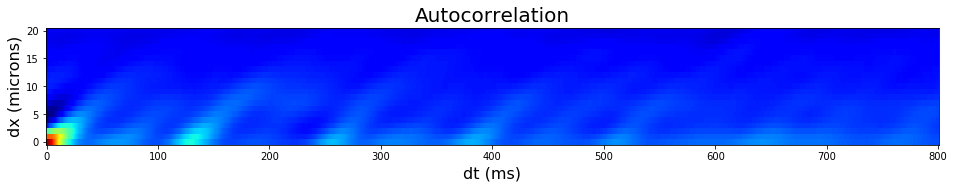

In [70]:
plt.figure(figsize = (16, 16))
plt.imshow(c.T, aspect = 5, origin = 'lower', cmap = mpl.cm.get_cmap('jet'))
plt.title('Autocorrelation', fontsize = 20)
plt.ylabel('dx (microns)', fontsize = 16)
plt.xlabel('dt (ms)', fontsize = 16)

Text(0.5, 0, 'dt (ms)')

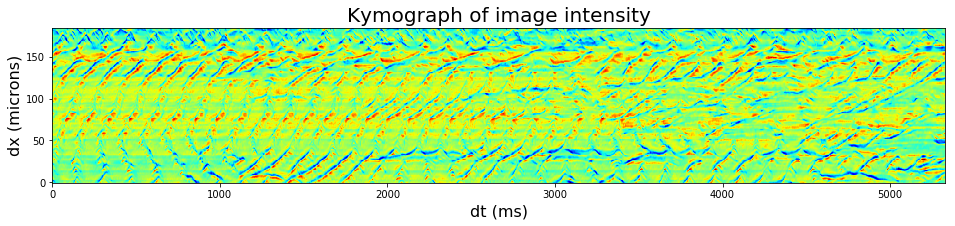

In [71]:
plt.figure(figsize = (16, 16))
plt.imshow(c_intensity.T, aspect = 5, origin = 'lower', cmap = mpl.cm.get_cmap('jet'))
plt.title('Kymograph of image intensity', fontsize = 20) 
plt.ylabel('dx (microns)', fontsize = 16)
plt.xlabel('dt (ms)', fontsize = 16)